# Ultimate Data Science Challenge
###### Chester Hitz | Data Science Career Track | July 24, 2018

## P1 - Exploratory Data Analysis

<div class="span5 alert alert-info">

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


</div>

In [1]:
import json
import numpy as np
import pandas as pd
import datetime as dt
import datetime as dt
import matplotlib.pyplot as plt
from collections import Counter
%run -i 'progress.py'

import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

logins = pd.read_json('logins.json')
print(logins.shape)
print(logins.head())


(93142, 1)
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


The first step is to bin the data by 15 minute intervals.

In [2]:
# create a dummy variable to aggregate
logins['count'] = 1
logins_agg = logins.groupby(pd.Grouper(key='login_time', freq='15min')).count()
logins_agg.sort_index(inplace=True)

From that, I can extract the month, day of the week, hour, and hour + minute (minute on it's own is meaningless)

In [3]:
# Extract month
logins_agg['month'] = logins_agg.index.month
logins_agg['month'] = logins_agg['month'].map(
    dict(zip(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])))

# Extract day of week, map values for weekday.
logins_agg['day_of_week'] = [dt.datetime.weekday(x) for x in logins_agg.index]
logins_agg['day_of_week'] = logins_agg['day_of_week'].map(
    {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'})

# Extract the week
logins_agg['week'] = logins_agg.index.week

# Extract hour into one column
logins_agg['hour'] = logins_agg.index.hour

# and the general time
logins_agg['minute'] = logins_agg.index.time

# Validate processing
print(logins_agg.shape)
print(logins_agg.head(5))
print(logins_agg.tail(5))

(9788, 6)
                     count month day_of_week  week  hour    minute
login_time                                                        
1970-01-01 20:00:00      2   Jan        Thur     1    20  20:00:00
1970-01-01 20:15:00      6   Jan        Thur     1    20  20:15:00
1970-01-01 20:30:00      9   Jan        Thur     1    20  20:30:00
1970-01-01 20:45:00      7   Jan        Thur     1    20  20:45:00
1970-01-01 21:00:00      1   Jan        Thur     1    21  21:00:00
                     count month day_of_week  week  hour    minute
login_time                                                        
1970-04-13 17:45:00      5   Apr         Mon    16    17  17:45:00
1970-04-13 18:00:00      5   Apr         Mon    16    18  18:00:00
1970-04-13 18:15:00      2   Apr         Mon    16    18  18:15:00
1970-04-13 18:30:00      7   Apr         Mon    16    18  18:30:00
1970-04-13 18:45:00      6   Apr         Mon    16    18  18:45:00


Now we have some good data to work with and visualize. The index is sorted and it is interesting to note that the data does not have rides past mid-April, so I am going to account for that when building my visualizations. 

### Monthly Ridership

The first, most basic thing to look at is the distribution of rides over the four months.

In [4]:
def bar_chart(x, y, title, xlabel, ylabel):
    t0 = go.Bar(
    x=x,
    y=y,
    marker=dict(color='#10898d')
    )

    data = [t0]
    layout = go.Layout(
        barmode='stack',
        title=title,
        yaxis=dict(title=ylabel),
        xaxis=dict(title=xlabel)
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='stacked-bar')
    
bar_chart(x=['Jan','Feb','Mar','Apr'],
          y=logins_agg.groupby('month').sum()['count'],
          title='Distribution of rides per Month',
          xlabel='Month',
          ylabel='# of Rides')

Generally, ridership seems to be going up. We can confirm this by plotting on a more granular level and looking at ridership per day over the study period. To assist, I've added a trend line.

In [5]:
d_series = logins.groupby(pd.Grouper(key='login_time', freq='1d')).sum()['count']
d_reg = np.polyfit(range(len(d_series)), d_series.values, 1)

# Create a trace
trace = go.Scatter(
    x = d_series.index,
    y = d_series.values,
    name='Riders'
)

reg_trace = go.Scatter(
    x = d_series.index,
    y = [(d_reg[0]*x)+d_reg[1] for x in range(d_series.shape[0])],
    name= 'Trend line',
    line=dict(color='#c14b22',dash='dot')
)

data = [trace, reg_trace]

iplot(data, filename='basic-line')
print('Ridership increase day-after-day (average):', d_reg[0])

Ridership increase day-after-day (average): 5.41401616659


Looking at the trend line generated from the polyfit, we can infer that ridership increases by 5 on average day after day.

We can also see that ridership goes in cycles week after week. By plotting the median ridership per day from each week on a plot, we can see what we already suspected: Ridership peaks on weekends, bottoms out on Monday, then rises steadily through the week.

In [6]:
n_weeks = max(logins_agg.week)
color_list = ['rgb({}, {}, {})'.format(x[0], x[1],x[2]) for x in sns.cubehelix_palette(n_weeks, start=.5, rot=-.75)]
days = ['Sat','Sun','Mon','Tue','Wed','Thur','Fri']

week_dict ={}
# Create a trace
for week in range(n_weeks):
    week_dict[week] = go.Scatter(
        x = days,
        y = [dict(logins_agg.query('week==%d'%week).groupby('day_of_week').sum()['count']).get(day) for day in days],
        name = week,
        line= dict(color=color_list[week])
    )
layout = dict(title = 'Total ridership for each week, by day of the week',
              xaxis = dict(title = 'Day of the Week'),
              yaxis = dict(title = 'Median number of riders'),
              )

data = list(week_dict.values())

fig = dict(data=data, layout=layout)
iplot(fig, filename='basic-line')

What about time of day? We can plot that as well.

In [7]:
xv_series = logins_agg.groupby('minute').sum()['count']

bar_chart(x=[str(x)[:-3] for x in xv_series.index],
          y=xv_series.values,
          title='Total Rides Per Time of Day',
          xlabel='Time of Day',
          ylabel='# of Rides')

While this is helpful, we know all days of the week are not the same. Therefore, I plot the days time of day as a stacked bar plot below. Reds represent the weekend, yellows are the early days of the week, and greens are the later days of the week.

In [8]:
day_dict= {}
colors = {'Mon':'#f9ab13', 'Tue':'#e2c25d', 'Wed':'#d0d595', 'Thur':'#c5dfba', 'Fri':'#bfe5cc','Sat':'#c14b22', 'Sun':'#f28143'}

for day in days:
    xv_series = logins_agg[logins_agg.day_of_week ==day].groupby('minute').sum()['count']
    day_dict[day] = go.Bar(
        x= [str(x)[:-3] for x in xv_series.index],
        y= list(xv_series.values),
        name = day,
        marker=dict(color=colors[day])
        )

data = list(day_dict.values())
layout = layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

As might be expected, demand fluctuates throughout the day and week. A few easy observations:
* Rides are much more requested in the early mornings on the weekends than other times of the week. This is due to people catching rides after drinking at bars and nightclubs most likely.
* People tend not to request rides so much in the morning, that is definitely the least demanded time, especially early in the week.
* There is a lot of demand around lunchtime during the week, but especially later in the week.
* Saturday and Sunday afternoon and evening have remarkably even demand throughout.

We can also look at this from another angle, by binning the times of day into categories (shown below) then showing what percentage of rides fall in those bins through the week. 

* 12AM - 4AM: Late night.
* 4AM - 8AM: Early morning.
* 8AM - 12PM: Late morning.
* 12PM - 4PM: Afternoon
* 4PM - 8PM: Evening
* 8PM - 12AM: Night

In [9]:
def time_of_day(x):
    if x <= 4: return 'Late Night'
    elif x <= 8: return 'Early Morning'
    elif x <= 12: return 'Late Morning'
    elif x <= 16: return 'Afternoon'
    elif x <= 20: return 'Evening'
    elif x <= 24: return 'Night'
    
logins_agg['time_of_day'] = logins_agg['hour'].apply(time_of_day).astype('category')

In [10]:
times_of_day = ['Early Morning', 'Late Morning', 'Afternoon', 'Evening', 'Night', 'Late Night']
td_cdict= {'Early Morning':'#e6f7fe', 'Late Morning':'#ceeffe', 
          'Afternoon':'#6a99bd', 'Evening':'#376893', 
          'Night':'#263a50', 'Late Night':'#1c222e'}

td_dict = {}
for td in times_of_day:
    td_dict[td] = go.Bar(
        x= days,
        y= [logins_agg[logins_agg.time_of_day == td].groupby('day_of_week').median()['count'][x] for x in days],
        name = td,
        marker=dict(color=td_cdict[td])
        )

data = list(td_dict.values())
layout = layout = go.Layout(
    title='Rides per day of Week w Times of Day',
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

This visual doesn't provide any new information necessarily, but it is an interesting way of looking at the main trends we've already explored. 

For one final visualization, mostly just for kicks - a 3D visualization of the data with day of week on the y-axis, time of day on the x-axis, and number of rides on the z-axis.

In [74]:
threed_dict= {}
colors = {'Mon':'#f9ab13', 'Tue':'#e2c25d', 'Wed':'#d0d595', 'Thur':'#c5dfba', 'Fri':'#bfe5cc','Sat':'#c14b22', 'Sun':'#f28143'}

three_d_df = pd.DataFrame()
for day in days:
    pivot_table = logins_agg.pivot_table(index='minute', columns='day_of_week', aggfunc='sum')['count'][day]
    df = pd.DataFrame(index=pivot_table.index, data=pivot_table.values, columns=['count'])
    df['day'] = pd.Series(index=pivot_table.index, data = [day]*df.shape[0])
    three_d_df = three_d_df.append(df)



In [84]:
threed_dict= {}
colors = {'Mon':'#f9ab13', 'Tue':'#e2c25d', 'Wed':'#d0d595', 'Thur':'#c5dfba', 'Fri':'#bfe5cc','Sat':'#c14b22', 'Sun':'#f28143'}

for day in days:
    xv_series = logins_agg[logins_agg.day_of_week ==day].groupby('minute').sum()['count']
    threed_dict[day] = go.Scatter3d(
        x= [str(x)[:-3] for x in xv_series.index],
        y= [day]*xv_series.shape[0],
        z = list(xv_series.values),
        name = day,
        mode='markers',
        marker=dict(color=colors[day])
        )

data = list(threed_dict.values())
layout = go.Layout(
    width=1000,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')

#### Conclusions
To conclude, I can say the following about Ultimate's ridership during the study period:
* Ridership generally increased from January to April.
* Each week followed roughly the same cycle with high demands on the weekend, especially late at night, and then growing demand through the workweek.
* Highest consistent demand periods: Weekday lunch, early morning Friday and Saturday, and weekend afternoons.
* Lower demand periods: Weekday mornings, earlier days of the week.

## Experiments and Metrics Design

<div class="span5 alert alert-info">

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

</div>

**What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

I would look at the difference (absolute value) between the number of rides served in each city in a given time period over the total number of rides during that time period:

        MPI = | Gotham rides - Metropolis rides | / Total Rides

* If a driver did 50 rides in Gotham and 50 rides in Metropolis, his score would be zero.

* If a driver did 25 rides in Gotham and 75 rides in Metropolis, her score would be .50.

* If a driver did 100 rides in Gotham and 0 rides in Metropolis, her score would be 1.

This metric (referred to as the KPI) could then be aggregated for all drivers (probably by taking the median to prevent against the influence of outliers).

This is a reasonable metric because it is robust to any outliers of drivers serving only one city, and also more indicative of how much time drivers actually spend in each city compared to an aggregate number, like total number of toll crossings. The goal of the program would be to get the number for drivers closer to zero. It should be noted that in order to do this, drivers would have to adjust their primary operating hours to cover both day and night.

**Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**a. How you will implement the experiment?**

In order to implement this experiment, I would create a control group and a treatment group of drivers who primarily drive in each city. The treatment group would have their toll costs reimbursed for the duration of the experiment, and the control group would not. The independent variable in this case would be participation in the reimbursement program, and the dependent variable would be the KPI discussed above, with the hypothesis being that participation in the program will lower the KPI. I would then measure the change of the KPI between the two groups over a certain period of time, probably a month or so after first implemented.

**b. What statistical test(s) you will conduct to verify the significance of the observation?**

There are two statistical methods that could be used here, a T-test to determine if the program had an effect by determing if the means of the treatment and control groups are statistically different from one and other. A permutation test is a similar test but swaps labels around between the two groups randomly and then determines if there is any actual meaningful difference between the labeled groups and the randomly labeled groups. Both tests are statistically powerful methods of determining the program's efficacy.

**c. How you would interpret the results and provide recommendations to the city operations team (along with any caveats.)?**

If the results of the previous two tests showed a statistically significant decrease in the mean of the KPI in the treatment group, then the program would be considered a success. I think a big caveat would depend on the duration of the experiment. If drivers are initially crossing between the two cities when the program is first offered to see how many rides they can get in an unfamiliar city, they might end up doing that less so over time depending on their success rate.

## Predictive Modelling

### Analyzing User Retention

#### Overview

The first question is: What percentage of users who signed up in January were actually retained by Ultimate into their sixth month? To answer this, I first load the data, then create the target variable ('retained') from the user's last trip. 

In [11]:
df = pd.DataFrame()

# there was some sort of error in the data that was preventing pd.read_json from executing
# this iterative method is a workaround, albeit much slower.
text = np.loadtxt('ultimate_data_challenge.json', delimiter='},', dtype=str)
for line in log_progress(text, every=1000):
        df = df.append((json.loads(line+'}')),ignore_index=True)

A Jupyter Widget

In [12]:
# changing string variables to timestamps
df['last_trip_date'] = pd.to_datetime( df['last_trip_date'] )

# Calculation of target variable, which answers the question: Did this user take a trip in June?
date_gate = max(df.last_trip_date) - dt.timedelta(days=30)
df['retained'] = df.last_trip_date >= date_gate

print(df['retained'].value_counts())
print(df['retained'].value_counts()/df.shape[0])

False    31196
True     18804
Name: retained, dtype: int64
False    0.62392
True     0.37608
Name: retained, dtype: float64


#### Preprocessing

In [13]:
df.to_csv('ultimate_data_challenge.csv')
df = pd.read_csv('ultimate_data_challenge.csv')

With the data loaded and the target variable created, I can begin cleaning the data and calculating and transforming variables that are more machine-readable.

In [14]:
# binary encoding of phone categories (simpler version of LabelEncoder and OneHotEncoder)
df['iphone'] = df.phone == 'iPhone'
df['android'] = df.phone == 'Android'

# simple two line OneHotEncoding of city
for city in df['city'].unique():
    df[city] = (df['city'] == city).map({True:1.0,False:0.0})

I drop several features from the training data, including the target array and date variables, as well as 'duration_active' as that is derived from the target variable. Also dropped are features that have been encoded ('phone' and 'city').

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import Imputer

imp = Imputer()

y = df.retained.map({True:1, False:0})
X = df.drop(['retained','signup_date','last_trip_date','city','phone','Unnamed: 0'], axis=1)
X_cols= X.columns
X = pd.DataFrame(imp.fit_transform(X), columns=X_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, train_size=.8, test_size=.2)

#### Analysis

Here I am going to train a Logistic Regression estimator and use it to identify important features in the data. The goal of this first step is to examine what features the algorith identifies as important when building the decision tree, not necessarily make the best predictions.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

lgr = LogisticRegression(C=1, penalty='l2').fit(X_train,y_train)
print("Accuracy | Training : ", accuracy_score(y_train, lgr.predict(X_train)))
print("Accuracy | Test     : ", accuracy_score(y_test, lgr.predict(X_test)))

Accuracy | Training :  0.71705
Accuracy | Test     :  0.7186


This is not a great result, but we can use it to see which features have positive and negative impacts on retention.

In [17]:
coefs = pd.Series(index=X.columns,data=lgr.coef_.ravel()).sort_values(ascending=False)

trace = go.Scatter(
    x = coefs.index,
    y = coefs.values,
    mode = 'markers',
    marker = dict( size = 10, color = 'red',
    line = dict(width = 2))
)

iplot([trace], filename='basic-scatter')

Looking at this, we can categorize the features into five rough categories:

* Major positive impact: Ultimate Black user, resident of "King's Landing", iPhone user.
* Minor positive impact: Had more trips in first 30 days, higher ratings of drivers.
* Negligible impact: Surge percentage, weekday percentage, average distance of trip.
* Minor negative impact: Average rating given by driver, average surge use.
* Major negative impact:  Resident of Winterfell, Android user, resident of Astapor.

This seems to line up with what we would expect, but let's do a quick reality check in the data.

In [18]:
df.groupby('city').mean()['retained']

city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: retained, dtype: float64

As we can see, the percentage of users from Winterfell that were retained (62%) is 27% higher than Winterfell (35%) and Astapor (25%). It makes sense that these variables would have such an effect. Checking retention rates per category of phone also reflects findings from this analysis.

In [19]:
df.groupby('phone').mean()['retained']

phone
Android    0.209426
iPhone     0.448933
Name: retained, dtype: float64

### Predicting User Retention

While a LogisiticRegressor is useful for analyzing retention factors, it is not as tuneable to characteristics of certain datasets as other models. For that reason, I will try to predict user retention using methods that utilize ensembles of decision trees, which are often high-performing when trained for classification and perform better on dense data. First step is to train an estimator with default parameters, and from there I tune the hyperparameters using GridSearchCV.

In [20]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

rfc= RandomForestClassifier(random_state=42).fit(X_train, y_train)

print("Accuracy | Training : ", accuracy_score(y_train, rfc.predict(X_train)))
print("Accuracy | Test     : ", accuracy_score(y_test, rfc.predict(X_test)))

Accuracy | Training :  0.97855
Accuracy | Test     :  0.7531


In [21]:
param_grid = {'max_depth':np.arange(1,6),
              'max_leaf_nodes': np.arange(10,101,10)}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid).fit(X,y)
print('Best parameters:', grid.best_params_)
print('Best parameters:', grid.best_score_)

Best parameters: {'max_depth': 5, 'max_leaf_nodes': 70}
Best parameters: 0.77396


GradientBoostingClassifiers can be powerful predictors as well.

Accuracy | Training :  0.788925
Accuracy | Test     :  0.7929


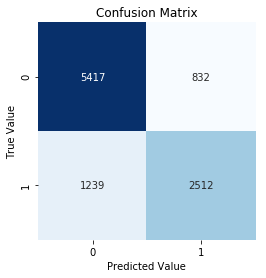

In [22]:
gbc = GradientBoostingClassifier().fit(X, y)

print("Accuracy | Training : ", accuracy_score(y_train, gbc.predict(X_train)))
print("Accuracy | Test     : ", accuracy_score(y_test, gbc.predict(X_test)))

c_mtx = confusion_matrix(y_test, gbc.predict(X_test))
sns.heatmap(c_mtx, square=True, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [29]:
print(classification_report(y_test, gbc.predict(X_test), target_names=['Not Retained', 'Retained']))

              precision    recall  f1-score   support

Not Retained       0.81      0.87      0.84      6249
    Retained       0.75      0.67      0.71      3751

 avg / total       0.79      0.79      0.79     10000



The precision is much higher than the recall, meaning more false negative predictions than false positives. As the classes here are pretty balanced (63/37) there is not much adjustment to be done in the way of imbalanced classes modification. 

The GradientBoostingClassifier that was built can predict just under 80% of customer retention, and should be a useful model going forward for Ultimate in conjunction with the insights from the analysis - namely that customers who are Ultimate Black users, residents of "King's Landing",and iPhone user are most likely to be retained after 30 days. Furthermore, the more trips users take in the first 30 days is indicative of a higher retention rate, so Ultimate can focus on getting people to take more rides in the first thirty days to become comfortable with the service.